# WORKFLOW

PRIMA PARTE
- Carica i dati
- Concateniamo i dati di train, val e test
- analisi di distribuzione sull'intero dataset
  - Question length distribution con pie chart e senza (media, mediana, moda)
  - Dsitribution per topic con plot
  - Distribuzione per grade con plot
  - Distribuzioni di context image-only, text-only, both, nothing

- Pulizia sull'intero dataset
   - Contare Term Frequencies
   - vocabolario iniziale autistico
   - puliamo (rimozione stopwords, etc.)
   - Word clouds su tutti i fields utili
   - vocabolario nuovo bucchino

- Suddivisione dell'intero dataset di nuovo
- analisi di distribuzione sui singoli (riusiamo funzioni definite prima)




# NLP Project - A.A. 2024/25

Authors:

- Gigante Davide (11018245)
- Puccia Niccolò (10829496)
- Sichili Giulio (11016179)
- Troiano Alessandro (10776474)

Link to the recording: AAAA

# Multimodal Question Answering: ScienceQA

# 0. Introduction

The dataset under study is **ScienceQA**, introduced in the NeurIPS 2022 paper *Learn to Explain: Multimodal Reasoning via Thought Chains for Science Question Answering*. ScienceQA is a large-scale benchmark designed to evaluate and improve the reasoning capabilities of AI systems on scientific multiple-choice questions.

This dataset is notable for its **multimodal** structure and its emphasis on **explainability** through annotated lectures and explanations that form a *chain-of-thought* (CoT). Unlike many previous benchmarks, which rely purely on textual information or offer limited domain coverage, ScienceQA includes:

* Over **21,000 examples**, each comprising a question, a set of answer choices, and a correct answer.
* **Multimodal contexts**, including both images and text passages.
* **Lectures** that provide general domain knowledge relevant to the question.
* **Explanations** that guide the reasoning process toward the correct answer.

Each question is mapped to a structured educational hierarchy that includes:

* **Grade level** (K–12),
* **Subject** (e.g., natural science, social science, language science),
* **Topic**, **Category**, and **Skill** fields, reflecting increasing specificity.

This rich annotation allows the dataset to support detailed analysis of both performance and reasoning quality, making it a valuable resource for developing interpretable and data-efficient QA models.



### Install Dependencies and libraries

In [1]:
!pip install datasets
!pip install wordcloud
!pip install --upgrade gensim

In [2]:
from datasets import load_dataset
from datasets import concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import mode
import re
import string
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import plotly.express as px

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Load Data

In [3]:
ds = load_dataset("derek-thomas/ScienceQA")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

(…)-00000-of-00001-1028f23e353fbe3e.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

(…)-00000-of-00001-6c7328ff6c84284c.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

(…)-00000-of-00001-f0e719df791966ff.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
})

In [5]:
def print_dataset_info(name, dataset):
    print(f"\n{name.upper()} DATASET")
    print(f"{'-'*len(name + ' DATASET')}")
    print(f"Number of examples: {len(dataset)}")
    print(f"Features: {dataset.column_names}")

# Data Subdivision
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

# Print Dataset Information
print_dataset_info("Train", train_ds)
print_dataset_info("Validation", val_ds)
print_dataset_info("Test", test_ds)


TRAIN DATASET
-------------
Number of examples: 12726
Features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']

VALIDATION DATASET
------------------
Number of examples: 4241
Features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']

TEST DATASET
------------
Number of examples: 4241
Features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']


### Exploring Data Types

In [6]:
def print_feature_types(name, dataset):
    print(f"\n{name.upper()} DATASET")
    print(f"{'-'*len(name + ' DATASET')}")
    print("Feature types:")
    for feature_name, feature_type in dataset.features.items():
        print(f"  - {feature_name:<10} : {feature_type}")

# Stampa dei tipi per ciascun dataset
print_feature_types("Train", train_ds)
print_feature_types("Validation", val_ds)
print_feature_types("Test", test_ds)


TRAIN DATASET
-------------
Feature types:
  - image      : Image(mode=None, decode=True, id=None)
  - question   : Value(dtype='string', id=None)
  - choices    : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
  - answer     : Value(dtype='int8', id=None)
  - hint       : Value(dtype='string', id=None)
  - task       : Value(dtype='string', id=None)
  - grade      : Value(dtype='string', id=None)
  - subject    : Value(dtype='string', id=None)
  - topic      : Value(dtype='string', id=None)
  - category   : Value(dtype='string', id=None)
  - skill      : Value(dtype='string', id=None)
  - lecture    : Value(dtype='string', id=None)
  - solution   : Value(dtype='string', id=None)

VALIDATION DATASET
------------------
Feature types:
  - image      : Image(mode=None, decode=True, id=None)
  - question   : Value(dtype='string', id=None)
  - choices    : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
  - answer     : Value(dtype='int8', id=None

As we can see, our dataset is composed of several fields, each serving a distinct role in structuring the question-answering task. Below is a detailed description of every feature, reflecting both its data type and its intended semantic function:

* **image**
  `Image(mode=None, decode=True, id=None)`
  Represents a contextual image that accompanies the question. This visual input may provide additional information necessary for interpreting the question or supporting the reasoning process.

* **question**
  `Value(dtype='string', id=None)`
  A natural-language prompt derived from the associated lecture content. It defines the main inquiry that the user must address.

* **choices**
  `Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)`
  A sequence of textual answer options. These choices represent possible responses to the question, among which only one is correct.

* **answer**
  `Value(dtype='int8', id=None)`
  An integer index pointing to the correct choice within the `choices` sequence. This serves as the ground-truth label for supervised learning tasks.

* **hint**
  `Value(dtype='string', id=None)`
  A supplementary piece of information designed to assist in solving the question. It does not directly provide the answer but helps guide the reasoning.

* **task**
  `Value(dtype='string', id=None)`
  A brief description of the nature of the activity being asked of the user, such as classification, comparison, or inference.

* **grade**
  `Value(dtype='string', id=None)`
  Indicates the educational level for which the question is intended, formatted as a string (e.g., "Grade 5"). This allows for curriculum alignment and difficulty scaling.

* **subject**
  `Value(dtype='string', id=None)`
  Specifies the broad academic domain relevant to the question, such as "Science," "Mathematics," or "Language."

* **topic**
  `Value(dtype='string', id=None)`
  Refines the `subject` field by denoting a specific thematic area, such as "natural-sciences," "social-science," or "language-science."

* **category**
  `Value(dtype='string', id=None)`
  A subdomain or subcategory of the given topic. This helps further narrow down the conceptual focus of the question.

* **skill**
  `Value(dtype='string', id=None)`
  Describes the cognitive skill or operation the user is expected to apply, such as "identify," "analyze," or "summarize."

* **lecture**
  `Value(dtype='string', id=None)`
  A text excerpt or lecture passage from which the question is derived. It provides the primary source of information or context.

* **solution**
  `Value(dtype='string', id=None)`
  A textual explanation outlining how the correct answer can be derived. This may include reasoning steps, calculations, or logical deductions.

# 1. Exploratory Data Analysis

In [ ]:
def print_context_stats(name, dataset):
    header = f"{name.upper()} CONTEXT STATS"
    print(f"\n{header}")
    print(f"{'-' * len(header)}")
    image_count = 0
    hint_count = 0
    both_count = 0
    none_count = 0

    for ex in dataset:
        has_image = ex['image'] is not None
        has_hint  = bool(ex['hint'])

        if has_image:
            image_count += 1
        if has_hint:
            hint_count += 1
        if has_image and has_hint:
            both_count += 1
        if not has_image and not has_hint:
            none_count += 1

    print(f"Questions with images           : {image_count}")
    print(f"Questions with hints            : {hint_count}")
    print(f"Questions with both image+hints : {both_count}")
    print(f"Questions without any context   : {none_count}")

    return image_count, hint_count, both_count, none_count

full_ds = concatenate_datasets([train_ds, val_ds, test_ds])
image_count, text_count, context_count, none_count = print_context_stats("Full", full_ds)


Totale esempi: 21208
Questions with images: 10332
Questions with hints: 10220
Questions with both hints and context: 6532
Questions with no context: 7188


<ipython-input-8-92455a56bd29>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='pastel')


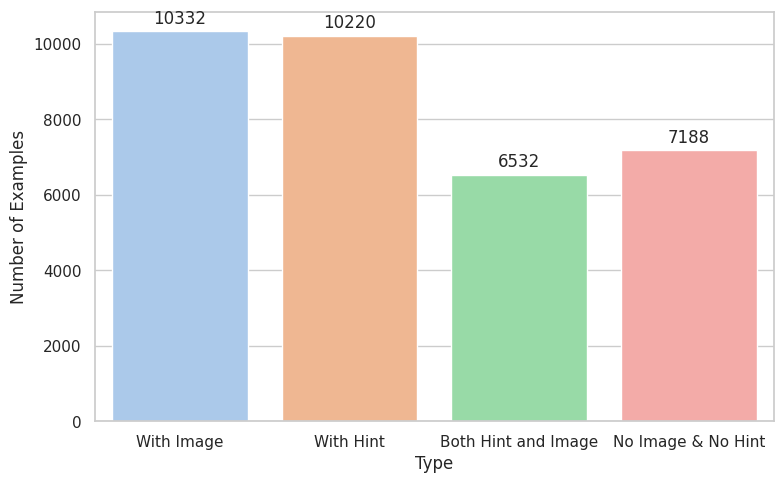

In [ ]:
# Data to plot
labels = ['With Image', 'With Hint', 'Both Hint and Image', 'No Image & No Hint']
counts = [image_count, text_count, context_count, none_count]

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Barplot
sns.barplot(x=labels, y=counts, palette='pastel')
plt.ylabel('Number of Examples')
plt.xlabel('Type')

# Annotate counts
for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.02, str(count), ha='center')

plt.tight_layout()
plt.show()

In [9]:
def plot_question_distribution_by_column(
    dataset, column, title, xlabel, rotation=60, palette='muted', sort_by_freq=True
):
    plt.figure(figsize=(14, 6))  # più larga

    data_df = dataset.to_pandas()

    if sort_by_freq:
        order = data_df[column].value_counts().index
    else:
        order = dataset.unique(column)

    ax = sns.countplot(x=column, data=data_df, order=order, palette=palette)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of Questions")
    plt.xticks(rotation=rotation, ha='right')

    # Aggiungi valori sopra le barre (opzionale ma utile)
    for p in ax.patches:
        ax.annotate(
            str(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom',
            fontsize=8, color='black',
            xytext=(0, 2),
            textcoords='offset points'
        )

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [10]:
def plot_question_length_distribution_from_column(
    dataset, text_column='question', title="Question Length Distribution", max_words=40, tick_interval=1
):
    data_df = dataset.to_pandas()
    data_df['question_length'] = data_df[text_column].apply(lambda q: len(q.split()))

    plt.figure(figsize=(14, 6))

    ax = sns.histplot(
        data_df['question_length'],
        bins=range(0, max_words + 1),
        kde=False,
        color='mediumseagreen',
        edgecolor='black'
    )

    plt.title(title)
    plt.xlabel("Number of Words in Question")
    plt.ylabel("Frequency")
    plt.xticks(np.arange(0, max_words + 1, step=tick_interval))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [11]:
def plot_question_length_statistics(dataset, text_column='question', title='Question Length Stats'):
    # Estrai lunghezze
    df = dataset.to_pandas()
    df['question_length'] = df[text_column].apply(lambda q: len(q.split()))
    lengths = df['question_length']
    mean_len = np.mean(lengths)
    median_len = np.median(lengths)
    mode_len = mode(lengths, keepdims=True).mode[0]
    std_len = np.std(lengths)
    max_len = int(lengths.max())
    min_len = int(lengths.min())

    # Print statistics
    print(f"\n{title}")
    print("=" * len(title))
    print(f"Mean:   {mean_len:.2f} words")
    print(f"Median: {median_len} words")
    print(f"Mode:   {mode_len} words")
    print(f"Std:    {std_len:.2f} words")

    # Plot
    plt.figure(figsize=(16, 7))
    sns.set_style("whitegrid")
    sns.histplot(lengths, binwidth=1, kde=True, color='#69b3a2', edgecolor='black', alpha=0.75)
    plt.xlim(left=min_len - 2, right=40)  # Stops x-axis at 40

    # Add lines + annotations
    y_max = plt.ylim()[1]
    for i, (val, label, color, style) in enumerate([
        (mean_len, f'Mean\n({mean_len:.2f})', '#e41a1c', '--'),    # red
        (median_len, f'Median\n({int(median_len)})', '#377eb8', '-.'),  # blue
        (mode_len, f'Mode\n({int(mode_len)})', '#4daf4a', ':'),     # green
    ]):
        plt.axvline(val, color=color, linestyle=style, linewidth=2)
        plt.text(val + 0.3, y_max * (0.85 - i * 0.1), label, color=color, fontsize=12, rotation=90, va='top')

    # Adjust x-axis
    buffer = 2
    plt.xlim(min_len - buffer, max_len + buffer)
    plt.xticks(np.arange(min_len, max_len + 1, step=max(1, (max_len - min_len) // 15)))

    plt.title(title, fontsize=16)
    plt.xlabel("Number of Words in Question", fontsize=13)
    plt.ylabel("Frequency", fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


<ipython-input-9-8725901ded2d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data_df, order=order, palette=palette)


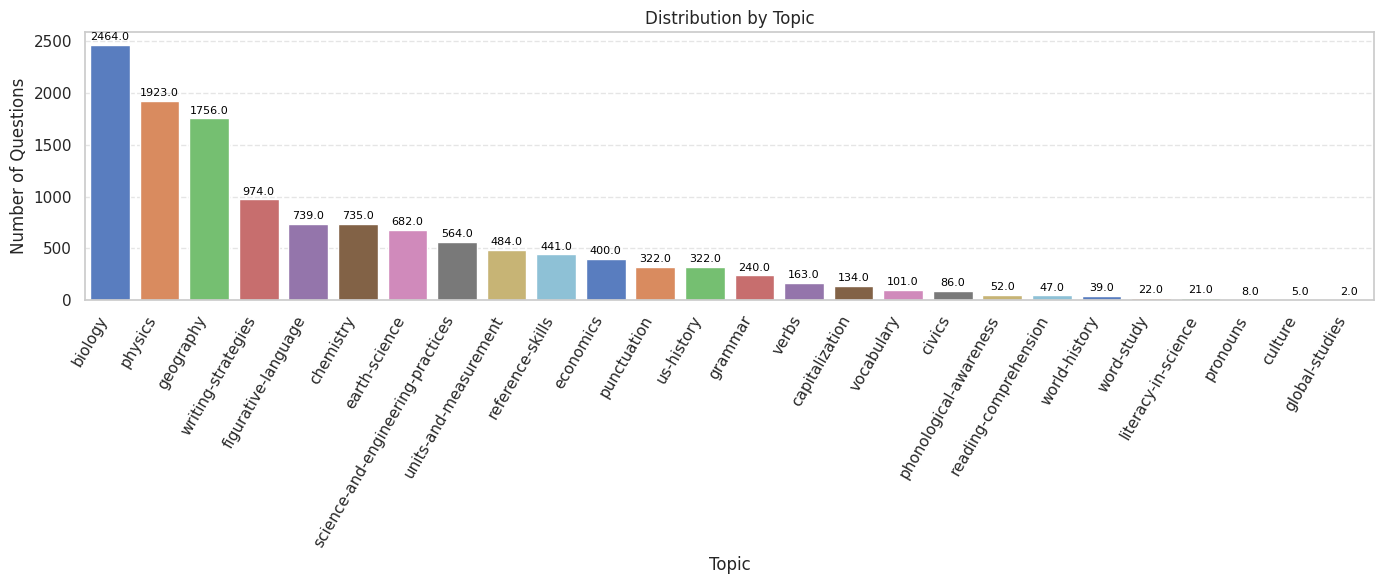

<ipython-input-9-8725901ded2d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=data_df, order=order, palette=palette)


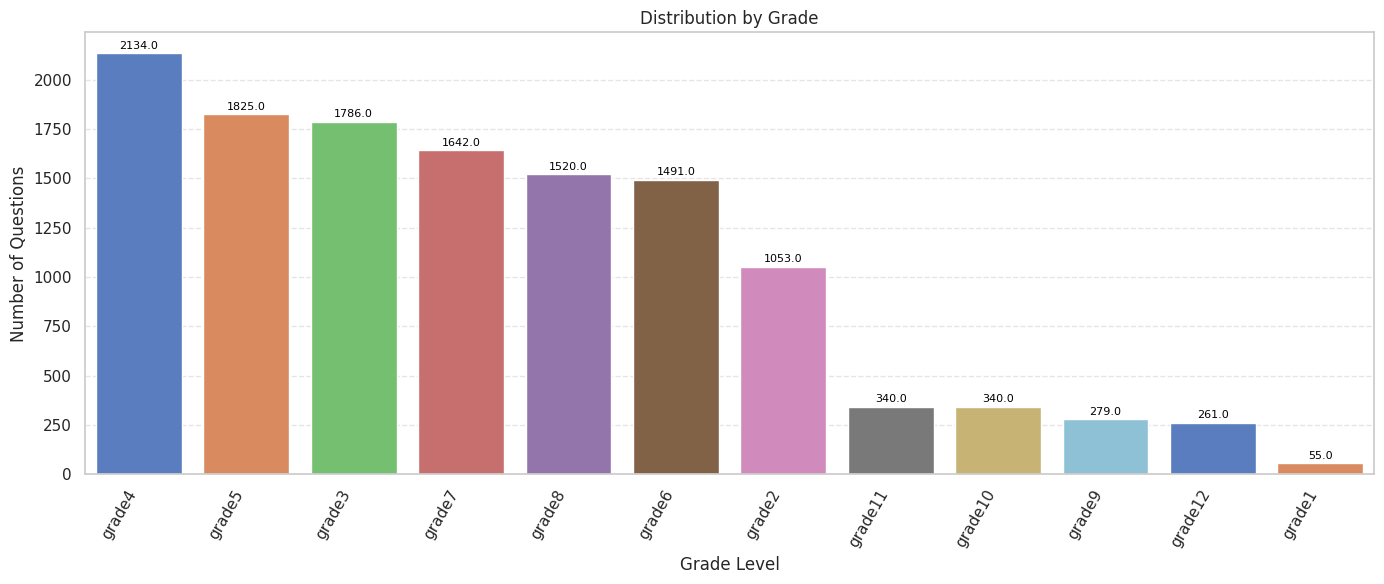

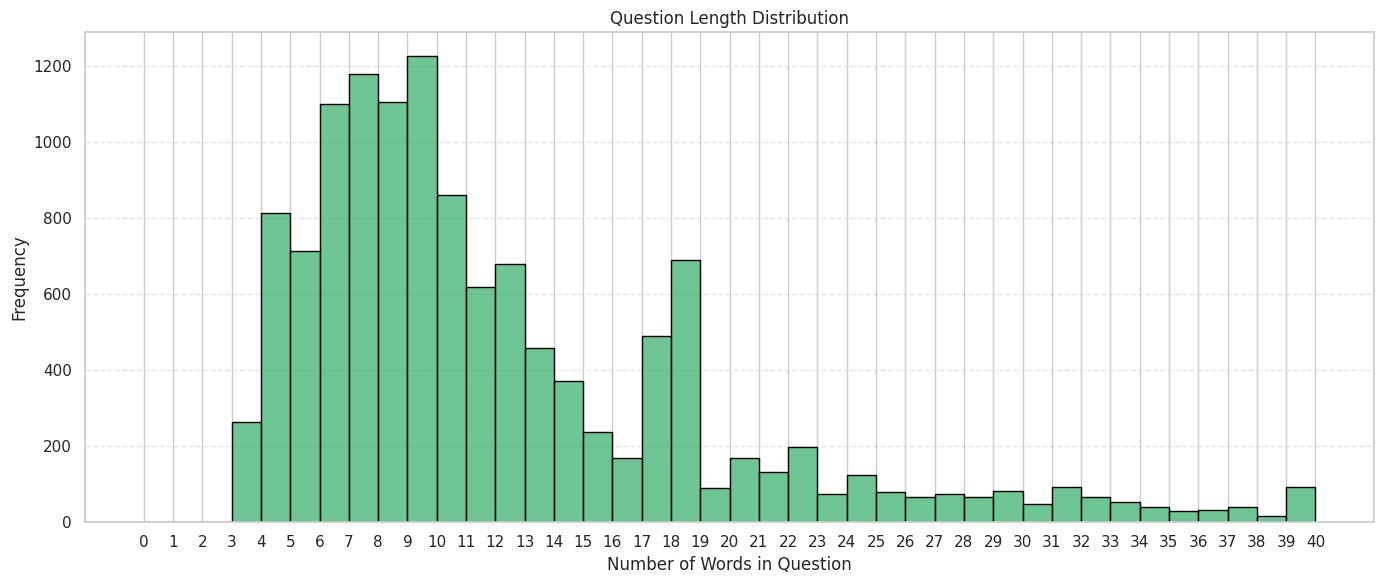


Question Length Stats
Mean:   12.20 words
Median: 9.0 words
Mode:   9 words
Std:    9.38 words


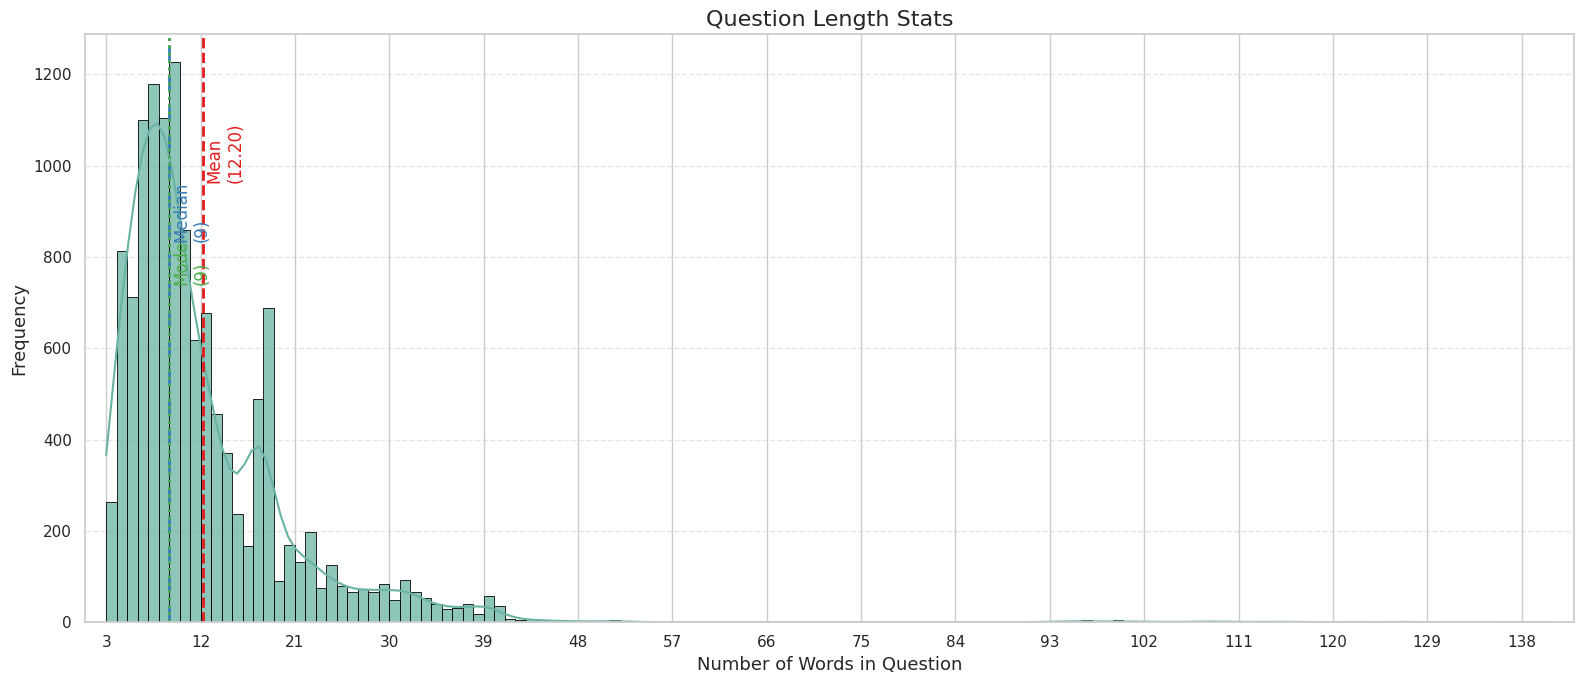

In [12]:
# topic class distribution
plot_question_distribution_by_column(train_ds, column="topic", title="Distribution by Topic", xlabel="Topic")

# grade level distribution
plot_question_distribution_by_column(train_ds, column="grade", title="Distribution by Grade", xlabel="Grade Level")

# question length histogram
plot_question_length_distribution_from_column(train_ds)

#question lenght statistic
plot_question_length_statistics(train_ds)

In [13]:
def plot_question_length_pie(dataset, text_column='question', title="Question Length Distribution (Pie Chart)"):
    df = dataset.to_pandas()
    df['question_length'] = df[text_column].apply(lambda q: len(q.split()))

    # Definisci fasce di lunghezza
    bins = [0, 5, 10, 15, 20, 1000]
    labels = ['0–5 words', '6–10 words', '11–15 words', '16–20 words', '21+ words']
    df['length_group'] = pd.cut(df['question_length'], bins=bins, labels=labels, right=True)

    # Conta le occorrenze per fascia
    group_counts = df['length_group'].value_counts().sort_index()

    # Dati per il pie chart
    sizes = group_counts.values
    group_labels = group_counts.index.tolist()

    # Plot a torta con legenda
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        sizes,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Pastel1.colors,
        textprops=dict(color="black")
    )

    # Aggiungi legenda esterna
    plt.legend(wedges, group_labels, title="Length Range", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.tight_layout()
    plt.show()


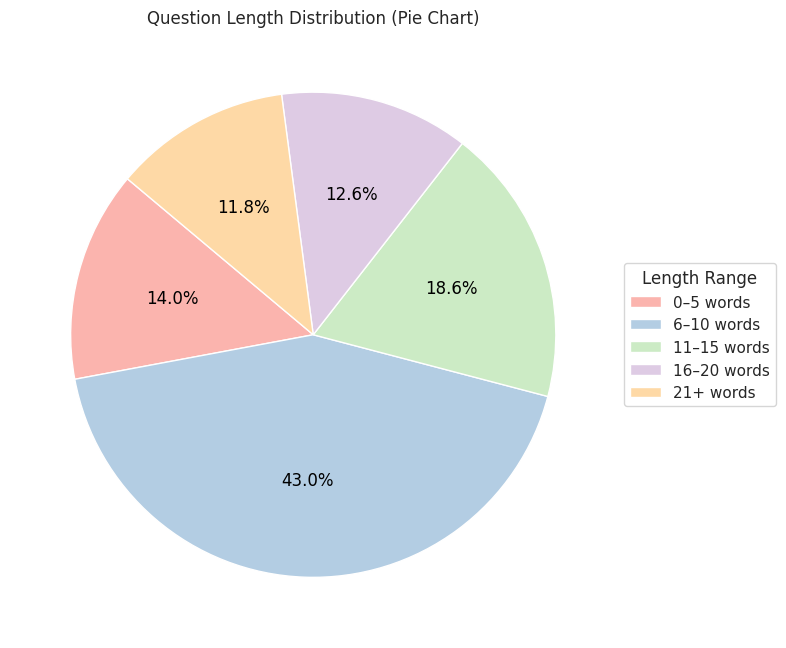

In [14]:
plot_question_length_pie(train_ds)


# 2. Data cleaning

### Overall term frequencies and word clouds

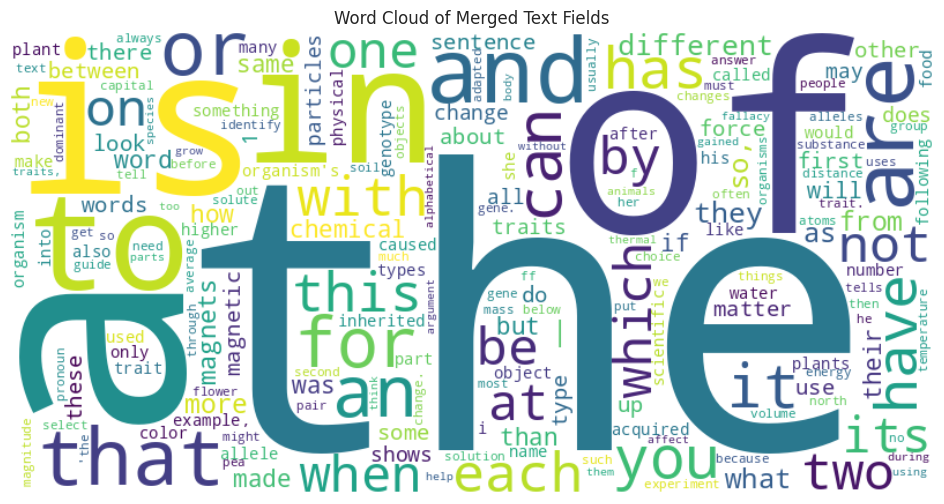

In [15]:
panda_df = full_ds.to_pandas()

# -> BEFORE STOP WORDS REMOVAL

# Merge fields 'question', 'context', 'title'
text_columns = ['question', 'choices', 'hint', 'lecture', 'solution']

# Convert all text columns to string
panda_df[text_columns] = panda_df[text_columns].astype(str)

# Combine text fields into one per row
panda_df['combined_text'] = panda_df[text_columns].agg(' '.join, axis=1)

# Concatenate all rows into one document
all_text = ' '.join(panda_df['combined_text'])


# Compute frequencies
from collections import Counter
words = all_text.lower().split()
word_freq = Counter(words)

# Create and display word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Merged Text Fields")
plt.show()


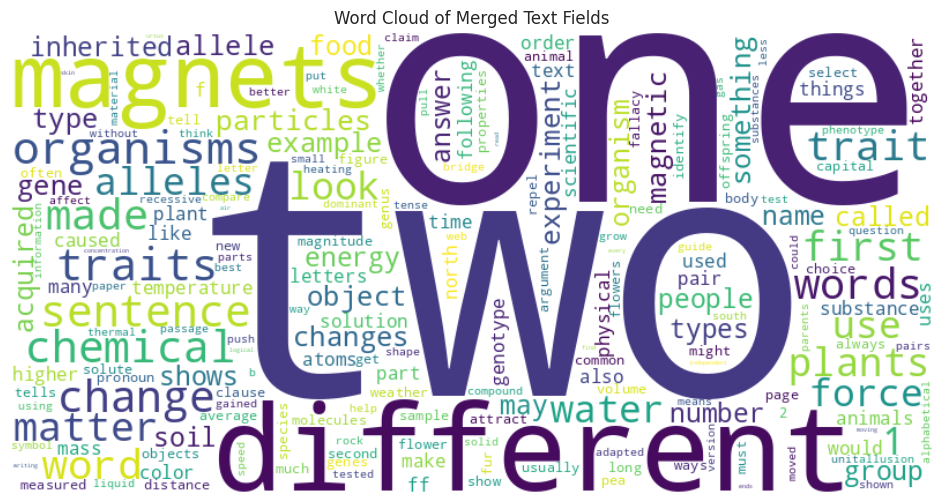

In [16]:
# -> AFTER STOP WORDS REMOVAL

# Remove punctuation and turn lowercase
regex = '[' + string.punctuation + ']'
nopunctuation_text = re.sub(regex,'',all_text)

# Removing stop words
words = nopunctuation_text.lower().split()
words_nostopwords = [w for w in words if w not in stopwords.words('english')]

word_freq = Counter(words_nostopwords)

# Create and display word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Merged Text Fields")
plt.show()

In [26]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

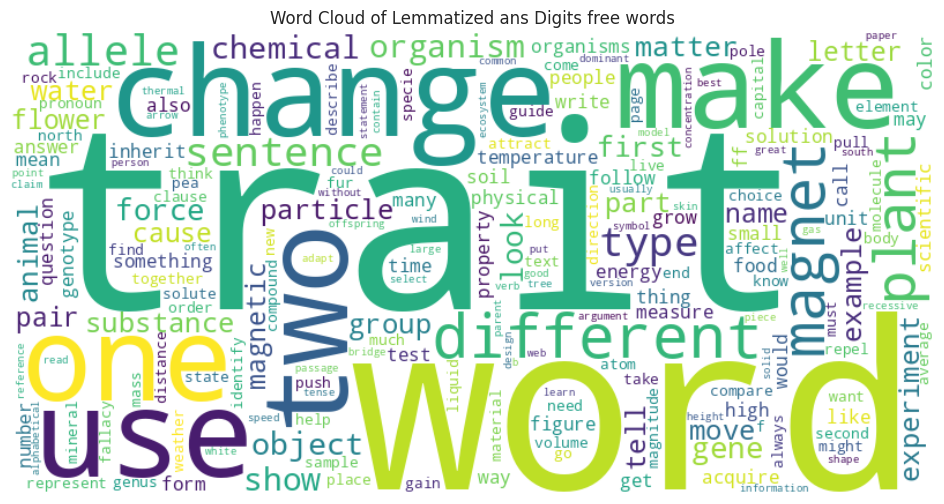

In [27]:
# AFTER DIGITS REMOVAL AND LEMMATIZATION

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Map POS tags to WordNet format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

# Your preprocessing function
def clean_and_lemmatize(text):
    # Remove punctuation
    regex = '[' + re.escape(string.punctuation) + ']'
    text = re.sub(regex, '', text.lower())

    # Tokenize and remove stopwords/digits
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and not t.isdigit()]

    # POS tagging
    tagged = pos_tag(tokens)

    # Lemmatize
    lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) for w, pos in tagged]
    return lemmatized

processed_words = clean_and_lemmatize(all_text)
word_freq = Counter(processed_words)

# Create and display word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Lemmatized ans Digits free words")
plt.show()

### Column wise word clouds

In [28]:
text_columns = ['question', 'choices', 'hint', 'lecture', 'solution']

# Make sure all text columns are strings
panda_df[text_columns] = panda_df[text_columns].astype(str)

# Loop over each column to generate and display a word cloud
for col in text_columns:
    print(f"Generating word cloud for column: {col}")

    # Get text content
    all_text = ' '.join(panda_df[col].tolist()).lower()

    # Remove punctuation and turn lowercase
    regex = '[' + string.punctuation + ']'
    nopunctuation_text = re.sub(regex,'',all_text)

    # Removing stop words
    words = nopunctuation_text.lower().split()
    words_nostopwords = [w for w in words if w not in stopwords.words('english')]
    # counts_nostopwords = nltk.Counter(words_nostopwords)
    # counts_nostopwords.most_common(20)

    word_freq = Counter(words_nostopwords)


    # Create WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200
    ).generate_from_frequencies(word_freq)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud: {col.capitalize()}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Bigram analysis
Instead of just unigrams (single words), we looked at frequently co-occurring word pairs (bigrams).

In [29]:
from nltk import ngrams
from collections import Counter

bigrams = ngrams(words_nostopwords, 2)
Counter(bigrams).most_common(20)


[(('magnetic', 'force'), 2034),
 (('scientific', 'name'), 1642),
 (('magnitude', 'magnetic'), 1309),
 (('text', 'uses'), 1254),
 (('pair', '1'), 1250),
 (('pair', '2'), 1250),
 (('first', 'word'), 1083),
 (('particles', 'sample'), 1055),
 (('answer', 'choice'), 973),
 (('magnets', 'pair'), 937),
 (('type', 'matter'), 922),
 (('physical', 'changes'), 916),
 (('chemical', 'changes'), 883),
 (('sample', 'b'), 853),
 (('look', 'picture'), 797),
 (('caused', 'heating'), 758),
 (('caused', 'cooling'), 758),
 (('arrow', 'pointing'), 740),
 (('higher', 'average'), 700),
 (('put', 'words'), 697)]

### Word2Vec

In [30]:
from gensim.utils import simple_preprocess

# Define text fields
text_columns = ['question', 'choices', 'hint', 'lecture', 'solution']

# Fill NaNs and convert to string
panda_df[text_columns] = panda_df[text_columns].fillna('')
panda_df[text_columns] = panda_df[text_columns].astype(str)

# Combine fields
panda_df['combined_text'] = panda_df[text_columns].agg(' '.join, axis=1)

# Remove empty or null combined_text
panda_df = panda_df[panda_df['combined_text'].notnull()]
panda_df = panda_df[panda_df['combined_text'].str.strip() != '']

# Apply gensim's simple_preprocess (lowercase, remove punctuation & short tokens)
sentences = panda_df['combined_text'].apply(lambda x: simple_preprocess(x, deacc=True)).tolist()

# Remove empty lists (some rows may be empty after tokenization)
sentences = [s for s in sentences if len(s) > 0]

# Check a sample
print(sentences[:2])


[['which', 'of', 'these', 'states', 'is', 'farthest', 'north', 'west', 'virginia', 'louisiana', 'arizona', 'oklahoma', 'maps', 'have', 'four', 'cardinal', 'directions', 'or', 'main', 'directions', 'those', 'directions', 'are', 'north', 'south', 'east', 'and', 'west', 'compass', 'rose', 'is', 'set', 'of', 'arrows', 'that', 'point', 'to', 'the', 'cardinal', 'directions', 'compass', 'rose', 'usually', 'shows', 'only', 'the', 'first', 'letter', 'of', 'each', 'cardinal', 'direction', 'the', 'north', 'arrow', 'points', 'to', 'the', 'north', 'pole', 'on', 'most', 'maps', 'north', 'is', 'at', 'the', 'top', 'of', 'the', 'map', 'to', 'find', 'the', 'answer', 'look', 'at', 'the', 'compass', 'rose', 'look', 'at', 'which', 'way', 'the', 'north', 'arrow', 'is', 'pointing', 'west', 'virginia', 'is', 'farthest', 'north'], ['identify', 'the', 'question', 'that', 'tom', 'and', 'justin', 'experiment', 'can', 'best', 'answer', 'do', 'ping', 'pong', 'balls', 'stop', 'rolling', 'along', 'the', 'ground', 'so

In [31]:
model = Word2Vec(
    sentences,
    vector_size=100,     # embedding dimensions
    window=5,            # context window
    min_count=2,         # ignore very rare words
    workers=4,           # threads
    sg=1                 # use skip-gram; set to 0 for CBOW
)
print("The size of the vocabulary is:", len(model.wv))


The size of the vocabulary is: 13411


In [32]:
term = 'magnet'
model.wv[term]

array([-0.91730076, -0.17475021, -0.30495122, -0.2510474 ,  0.15042965,
        0.01687443,  0.20217964,  0.03662865, -0.57509184, -0.36838832,
        0.68994963,  0.25329658,  0.24769951, -0.14542885,  0.7289899 ,
       -0.82656205, -0.72256863, -1.0033256 ,  0.29047102,  0.5629364 ,
       -0.53400743,  0.04943055, -0.6622144 ,  0.09016691,  1.2001902 ,
       -0.7300907 , -0.59041744, -0.5776879 ,  0.6693314 ,  0.45509177,
        0.46881956, -0.513661  ,  0.72012657,  0.35209495, -1.0263758 ,
        1.2234446 , -0.8976141 , -0.43640885, -0.6827814 , -0.94913006,
       -0.08129866, -0.8483284 ,  0.04657847,  0.47222266,  0.7116442 ,
        0.12231868, -0.2601941 ,  0.6667801 , -0.02545342,  0.47071502,
        0.41674498, -0.6484783 , -0.35197428,  0.22685367,  0.33185   ,
        0.41928694, -0.05484597, -0.8508348 ,  0.17127652,  0.59820294,
        0.14341159, -0.6626336 ,  0.03576281, -0.03081118, -0.44657883,
        0.79587835,  0.24962929,  0.18441235, -0.15190823,  1.38

In [33]:
model.wv.most_similar(term)

[('poles', 0.6886588931083679),
 ('magnets', 0.6582555770874023),
 ('attracts', 0.6573089957237244),
 ('closest', 0.6458213925361633),
 ('pole', 0.6356675028800964),
 ('disc', 0.6286115050315857),
 ('repels', 0.6262115836143494),
 ('repel', 0.5920292139053345),
 ('mover', 0.5860900282859802),
 ('strollers', 0.5791104435920715)]

In [34]:
#Embedding visualization

import random
from sklearn.decomposition import PCA

# Sample 100 words from your trained Word2Vec model
sample = random.sample(list(model.wv.key_to_index), 100)

# Extract vectors for sampled words
word_vectors = np.array([model.wv[word] for word in sample])

# Apply PCA
pca = PCA(n_components=3)
pca_embedding = pca.fit_transform(word_vectors)

# Split into coordinates
x, y, z = pca_embedding[:, 0], pca_embedding[:, 1], pca_embedding[:, 2]

# Create interactive 3D plot
fig = px.scatter_3d(
    x=x, y=y, z=z, text=sample,
    title="PCA of Word2Vec Embeddings",
)
fig.update_traces(marker=dict(size=4, line=dict(width=1)), textfont_size=10)
fig.show()



In [35]:
# Anchor words
names = ['magnet', 'force', 'pole']

# Sample 100 random words (excluding anchor words)
sample = random.sample([w for w in model.wv.key_to_index if w not in names], 100)

# Combine known and sampled words
all_words = names + sample

# Get vectors
word_vectors = np.array([model.wv[word] for word in all_words])

# PCA projection
pca = PCA(n_components=3)
embedding = pca.fit_transform(word_vectors)
x, y, z = embedding[:, 0], embedding[:, 1], embedding[:, 2]

# Define zoomed-in 3D plot
fig = px.scatter_3d(
    x=x, y=y, z=z,
    text=names + [None] * len(sample),
    title="Zoomed-In PCA of Word2Vec Embeddings"
)

# Set camera closer to center and scale down axes range
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-15, 15]),
        yaxis=dict(range=[-15, 15]),
        zaxis=dict(range=[-15, 15]),
        camera=dict(
            eye=dict(x=0.7, y=0.7, z=0.5)  # closer perspective
        )
    )
)

fig.update_traces(marker=dict(size=3, line=dict(width=1)), textfont_size=10)
fig.show()

# 3. Extensions

## 3.1 RAG Voice Interactive Model

## 3.2 - Topic Classification

## 3.3 Topic Modelling